In [1]:

#load standard libraries and set graphing styles
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
from glob import glob
import  struct 
import matplotlib.pyplot as plt
import os
import seaborn as sns
from scipy.stats import norm
from scipy.signal import savgol_filter 

large = 18
med = 18
small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (8, 6),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-v0_8-darkgrid')

 
from array import array

def loadMI(filename):
    size=os.path.getsize(filename)
    current=[]
    
    baseTime=os.path.getctime(filename)
    distance=[]
    times=[]
    velocity=[]
    distances=[]
    data = array('B')
    isSpectroscopy=True
    with open(filename, "rb") as file1:
        # Reading form a file
        d=file1.readline()
        chunks=[]
        while d!='data          BINARY\n' and d!='data          BINARY_32\n':
            d=file1.readline()
            
            d=d.decode('ascii')
            dd=d.strip().split(' ')
            if dd[0]=='plotType      Spectroscopy':
                isSpectroscopy=True
            if dd[0]=='dateModified':
                ts = " ".join(dd[1:]).strip()
                ts=pd.to_datetime(ts, infer_datetime_format=True)
                ts=ts.value/1000000000
                #if np.abs(ts-baseTime)>10:
                #    baseTime=ts
                    
            if  dd[0]==('bias'):
                bias =float(dd[-1]) 
                
            if  d.startswith('chunk'):
                parts = d.split('\t')
                dist=float(parts[5])
                time0=float(parts[2])
                time=float(parts[3])
                valueO=float(parts[4])
                chunks.append({'points':int(parts[1]),
                               'distperpoint':dist, 
                               'timeperpoint':time,
                               'startValue':valueO,
                               'time0':time0})

        loc = file1.tell()
        binarySize =size-loc
        data.fromfile(file1,binarySize )
        i=0
        while True:
                cDist=0
                for chunk in chunks:
                    chunkDist=[]
                    chunkCurrent=[]
                     
                    if isSpectroscopy:
                        cDist=chunk['startValue']
                        

                    for j in range(0,chunk['points']):
                        try:
                            f=(struct.unpack('<f', data[i:i+4]))
                        except:
                            return distance,current,bias,times,np.array(velocity) ,np.array(distances)
                        chunkCurrent.append(f)
                        cDist+=chunk['distperpoint']
                        chunkDist.append(cDist)
                        i+=4
                
                    dist=np.array(chunkDist)
                    if len(dist)>0:
                        distance.append(dist)
                        current.append(np.array(chunkCurrent).ravel()) 
                        totalTime=len(chunkDist)*chunk['timeperpoint']
                        time= chunk['time0']+ np.linspace(0, totalTime, len(chunkDist))
                    
                        times.append(time )
                        if len(dist)>0:
                            distances.append((dist[0]-dist[-1]))
                            velocity.append((dist[0]-dist[-1])/(time[0]-time[-1]))
            
    
    

file = r'S:\Research\Chip Fabrication Meeting Notes (Do not share without permission)\SharedData\AFM\CSAFM\20240625_C6_OH\C6OH_240625_141503.mi'  
#for file in dataFiles:
#    print(file)
distance,currents,bias,times,velocity,distances=loadMI(file)
    #break
 
print(len(distance)) 

1


C:\Users\bashc\AppData\Local\Temp\ipykernel_23704\3065327713.py:56: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  ts=pd.to_datetime(ts, infer_datetime_format=True)


C:\Users\bashc\AppData\Local\Temp\ipykernel_13812\507231625.py:27: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  ts=pd.to_datetime(ts, infer_datetime_format=True)


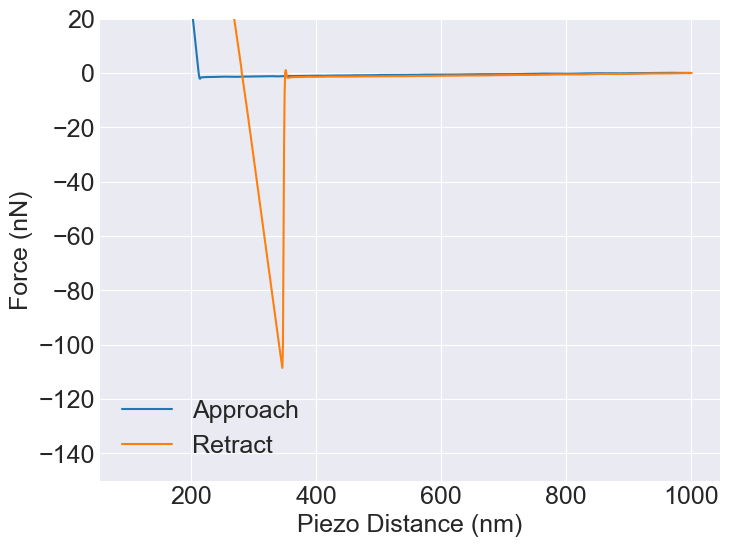

In [43]:
file =r'S:\Research\Chip Fabrication Meeting Notes (Do not share without permission)\SharedData\AFM\CSAFM\20240621_C11\ForceCalibration2_240621_140623_00002.mi'
distance,currents,bias,times,velocity,distances=loadMI(file)
for j in range(0,len(distance)):
    if j==0:
        label ="Approach"
        min = currents[j][0]
    else:
        label="Retract"
    plt.plot(distance[j]*1e9,(currents[j]-min)*9.5*3,label=label)
    
plt.legend()    
plt.ylim([-150,20])
plt.xlabel('Piezo Distance (nm)')
plt.ylabel('Force (nN)')    
plt.show()

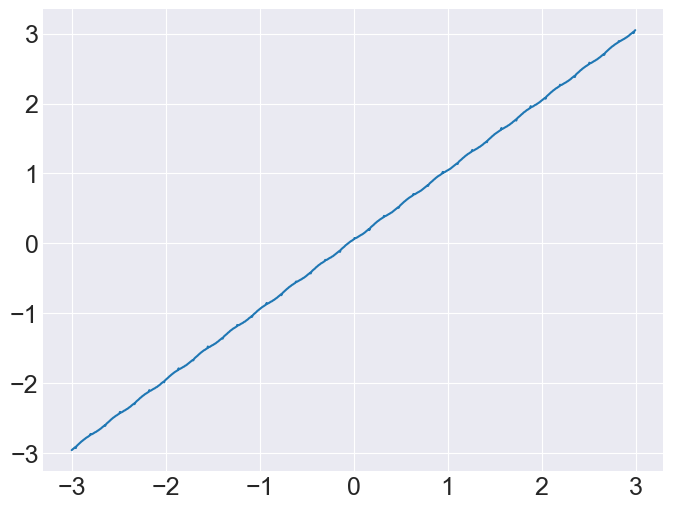

In [3]:
cc=0
for j in range(0,len(distance)):
 
    plt.plot(distance[cc],currents[cc])
    cc+=1
    
    #plt.ylim([0.04,.08])
    plt.show()

C:\Users\bashc\AppData\Local\Temp\ipykernel_13812\507231625.py:27: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  ts=pd.to_datetime(ts, infer_datetime_format=True)


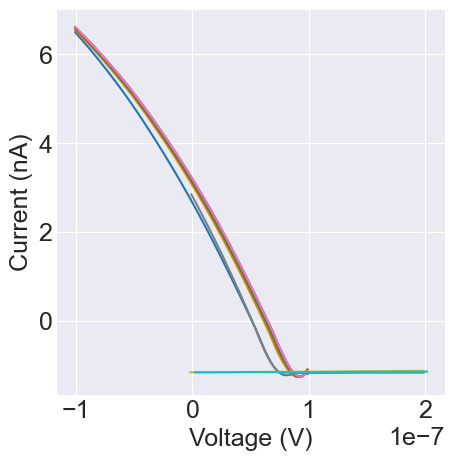

In [28]:
#use saveoy gol to filter and smooth the data

path=r'S:\Research\Chip Fabrication Meeting Notes (Do not share without permission)\SharedData\AFM\CSAFM\20240703_C9_Repeat_NewTip\MaybeC11\Force'

dataFiles = glob(path + r"\*.mi", recursive=False)
desiredPattern = 'IV'
desiredFiles = [file for file in dataFiles if desiredPattern in file]
desiredFiles = sorted(desiredFiles)
cc=0
plt.figure(figsize=(5,5))
for file in desiredFiles:
    distance,currents,bias,times,velocity,distances=loadMI(file)
    for j in range(0,len(distance)):
        try:
            current=savgol_filter(currents[j], 41, 3)
            plt.plot(distance[j],current,label=str(cc))
            cc+=1
        except:
            pass
    if cc>9:
        break
#plt.legend()
plt.xlabel('Voltage (V)')
plt.ylabel('Current (nA)')
plt.show()



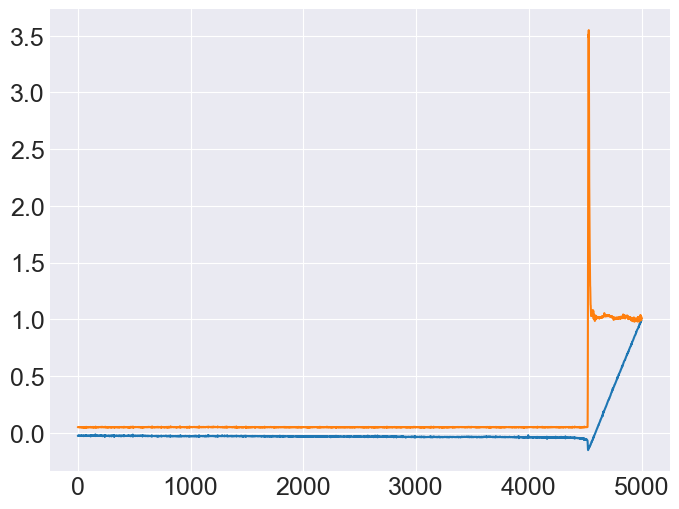

In [49]:
plt.plot(current)
plt.plot(force)

In [20]:
res = 256
grid = np.zeros((res,res))
#load the all the npy files from the directory
folder = r'S:\Research\Chip Fabrication Meeting Notes (Do not share without permission)\SharedData\AFM\CSAFM\20240715_C11_B\NIData\20270715_C11_pos_p2'
#folder =r'S:\Research\Chip Fabrication Meeting Notes (Do not share without permission)\SharedData\AFM\CSAFM\20240703_CTPR4\NIData\20240703_C4'
#folder =r'S:\Research\Chip Fabrication Meeting Notes (Do not share without permission)\SharedData\AFM\CSAFM\20240703_C9_Repeat_NewTip\NIData\20240703_C9_NewTip'
#folder =r'S:\Research\Chip Fabrication Meeting Notes (Do not share without permission)\SharedData\AFM\CSAFM\20240625_C6_OH\NIData\20240625_C6OH_1V'
files = glob(folder + r"\*.npy", recursive=False)
data = []
cc=0

xRange=50
highF=.3
lowF=.1
for file in files:
    currents = np.load(file)
    current = np.abs(currents[1])
    force = currents[0]

    if np.min(force[0])<lowF and np.max(force[-1])>highF:
        try:
            nmPPoint=  13.33*(highF-lowF)/len( force[ (force>lowF) & (force<highF)])  #nm/point
            cut = np.argwhere( current>.3)
            
            if len(cut)>0:
               
                cut=cut[:,0]
                current=np.abs(current[:(cut[0]+10)])
                force=force[:(cut[0]+10)]
                

                cutForce = np.argwhere( force>.5)
                if len(cutForce)>0:
                
                    x=np.linspace(0,len(current)*nmPPoint,len(current))
                    xx=x-x[cutForce[0]]+10

                    #plt.plot(xx,current)

                    #early = current[xx<2]
                    #if len(early)>10:
                    #    early = np.max( early)
                    #    if early<.1:
                    if True:
                            #plt.ylim([-0.5,1.5])
                            for j in range(len(xx)):
                                x=xx[j]
                                I=current[j]
                                
                                I=np.abs(I-.07)
                                x=int(x/xRange*res)
                                y=res-int(I/.3*res)
                                if x>0 and x<res and y>0 and y<res:
                                    grid[y,x]+=1
                    #if cc>10:
                    #    break
                    #cc+=1
                    
                     
        except:
            pass

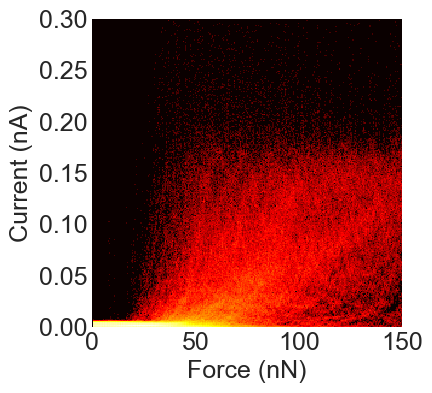

In [21]:
plt.figure(figsize=(4,4))
 
plt.imshow(np.log(1+grid), cmap='hot', extent=[0,xRange*3,0,.3],aspect='auto', interpolation='nearest')       
plt.grid(None)
plt.xlabel('Force (nN)')
plt.ylabel('Current (nA)')
plt.show()

C:\Users\bashc\AppData\Local\Temp\ipykernel_23704\3065327713.py:56: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  ts=pd.to_datetime(ts, infer_datetime_format=True)


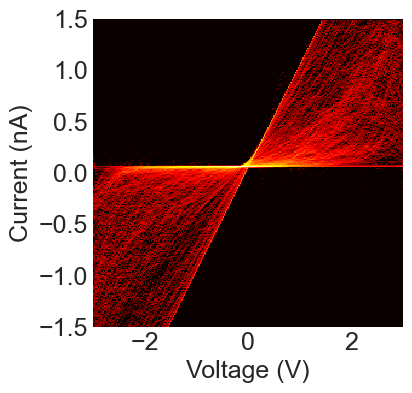

In [17]:
res = 256
grid = np.zeros((res,res))
#load the all the npy files from the directory
 
  
files =[
    #r'S:\Research\Chip Fabrication Meeting Notes (Do not share without permission)\SharedData\AFM\CSAFM\20240715_C11_B\IVs\Volume2\C11_240715_111938.mi',
        r'S:\Research\Chip Fabrication Meeting Notes (Do not share without permission)\SharedData\AFM\CSAFM\20240715_C11_B\IVs_Envchanber\Volume_ENV_3to3V_240715_140150.mi',
        r'S:\Research\Chip Fabrication Meeting Notes (Do not share without permission)\SharedData\AFM\CSAFM\20240715_C11_B\IVs_Envchanber\Volume_ENV_3to3V_240715_140616.mi'
        ]
 
data = []
cc=0

xRange=60
highI=1.5
lowI=-1.5
newX = np.linspace(-3,3,res)
for file in files:
    distance,currents,bias,times,velocity,distances=loadMI(file)
    for j in range(0,len(distance)):
       
        current=savgol_filter(currents[j], 41, 3)
        volts = distance[j]
        ind = np.argsort(volts)
        volts = volts[ind]
        current = current[ind]
        current= np.interp(newX, volts, current)
        if np.max(current)>.1 and np.min(current)<-.1: 
            for x in range(res):
                y=int( (current[x]-lowI)/(highI-lowI)*res)
                if y>0 and y<res:
                    grid[res-y,int(x)]+=1

       
plt.figure(figsize=(4,4))
 
plt.imshow(np.log(1+grid), cmap='hot', extent=[np.min(newX),np.max(newX),lowI,highI],aspect='auto', interpolation='nearest')       
plt.grid(None)
plt.xlabel('Voltage (V)')
plt.ylabel('Current (nA)')
plt.show()          

     

C:\Users\bashc\AppData\Local\Temp\ipykernel_19924\3065327713.py:56: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  ts=pd.to_datetime(ts, infer_datetime_format=True)


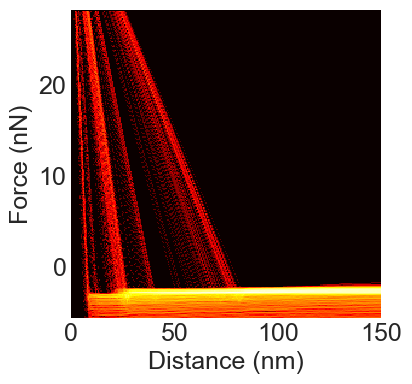

In [94]:
res = 256
grid = np.zeros((res,res))
#load the all the npy files from the directory
 
files =[r'S:\Research\Chip Fabrication Meeting Notes (Do not share without permission)\SharedData\AFM\CSAFM\20240702 CTPR8 NT\NewTip\ID_Volume\IV_Volume_240702_160703.mi']
 
 
data = []
cc=0

xRange=150
highI=1 
lowI=-.2
newX = np.linspace(0,xRange,res)
for file in files:
    distance,forces,bias,times,velocity,distances=loadMI(file)
    for j in range(0,len(distance)):
        cut = np.argwhere( forces[j]>1)
        if len(cut)>0:
            cut=cut[:,0]
            force=forces[j][:(cut[0])]
            dist=distance[j][:(cut[0])]
            dist = dist - dist[-1]
            ind = np.argsort(dist)
            dist = dist[ind]*1e9
            force = force[ind]+.5

            force= np.interp(newX, dist, force)
         
            for x in range(res):
                y=int( (force[x]-lowI)/(highI-lowI)*res)
                if y>0 and y<res:
                    grid[res-y,int(x)]+=1


plt.figure(figsize=(4,4))
 
plt.imshow(np.log(1+grid), cmap='hot', extent=[np.min(newX),np.max(newX),lowI*9.4*3,highI*9.4*3],aspect='auto', interpolation='nearest')       
plt.grid(None)
plt.xlabel('Distance (nm)')
plt.ylabel('Force (nN)')
plt.show()